In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import scipy as sp
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from textblob import TextBlob, Word

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [16]:
import os
import sys
os.environ['SPARK_HOME'] = "C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7"
sys.path.append("C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7\python")
sys.path.append("C:\Users\Pedro\Downloads\spark-2.0.2-bin-hadoop2.7\spark-2.0.2-bin-hadoop2.7\python\lib\py4j-0.8.2.1-src.zip")

#from spark_sklearn import GridSearchCV

In [2]:
movie_ratings = pd.read_pickle('movie_ratings.pkl')

In [3]:
class SentimentMetrics(TransformerMixin):
    def changes (self, sentiments):
        N_changes = 0
        for i in range(len(sentiments)-1):
            if sentiments[i]*sentiments[i+1] < 0:
                N_changes+=1
        return N_changes     
    
    def sentiment(self, script, pages = 100, ma = 5):
        #Creates a moving average of the sentiment polarity of the script pages (or %)
        sentiment = []
        for i in range(pages+1-ma):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+ma)*len(script)/pages]).sentiment.polarity)
        return sentiment    
        
    def transform(self, X, **transform_params):  
        S = X.apply(lambda x: SentimentMetrics.sentiment(self, x))
        sentiment_dic = {
       'Range': S.apply(lambda x: max(x) - min(x)),
       #'Sentiment_avg': S.apply(lambda x: x.mean()),
       #'Sentiment_std': S.apply(lambda x: x.std()),
       'Max_sentiment': S.apply(lambda x: max(x)),
       'Max_sentiment_loc': S.apply(lambda x: x.index(max(x))),
       'Min_sentiment': S.apply(lambda x: min(x)),
       'Min_sentiment_loc': S.apply(lambda x: x.index(min(x))),
       'Max_pos_change': S.apply(lambda x: pd.Series(x).diff(1).max()),
       'Max_pos_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).max())),
       'Max_neg_change': S.apply(lambda x: pd.Series(x).diff(1).min()),
       'Max_neg_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).min())),
       'Begin_sentiment': S.apply(lambda x: x[0]),
       'End_sentiment': S.apply(lambda x: x[-1]),
       'Total_change': S.apply(lambda x: x[-1] - x[0]),
       'plot_twist_index': S.apply(lambda x: (max(x[-10:]) - min(x[-10:]))/(max(x[:-10]) - min(x[:-10]) + 0.01)),
       'pol_changes': S.apply(lambda x: SentimentMetrics.changes(self, x))
        }
            
        return sp.sparse.csr_matrix(pd.DataFrame(sentiment_dic).astype(float))
    
        
    
    def fit(self, X, y=None, **fit_params):
        return self      

class NamedEntities(TransformerMixin):        
    def number_entities(self, text):
        upper = [i for i in TextBlob(text).words if (i.isupper() and i.lower() not in stopwords.words('english'))]
        tagged = pos_tag(upper)
        return len(set([word for word,pos in tagged if pos == 'NNP']))
    
    def transform (self, X):
        return pd.DataFrame(X.apply(lambda x: NamedEntities.number_entities(self,x)))
    
    def fit(self, X, y=None, **fit_params):
        return self      
        
        

class SelectColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def transform(self, X, **transform_params):
        return X[self.column]
    
    def fit(self, X, y=None, **fit_params):
        return self      

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def sentence_tokenize(text):
    words = TextBlob(text.replace(',', '.')).sentences
    return [word for word in words]
   
from sklearn import decomposition

from sklearn.base import BaseEstimator
class DenseTransformer(TransformerMixin, BaseEstimator):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [4]:
pipe_genre = Pipeline([('select_genre', SelectColumn('Genre')),
                       ('vect', CountVectorizer())])

pipe_script = Pipeline([('select_script', SelectColumn('script')),
                       ('union', FeatureUnion([('sentiment', SentimentMetrics()), ('named', NamedEntities())]))])

features = FeatureUnion([('script', pipe_script), ('genre', pipe_genre)])
preprocess = Pipeline([('dense', DenseTransformer()),
                       ('zscore', StandardScaler())])

In [5]:
##DELETE AFTER##
import cPickle as pickle
with open('test_sparse_array.dat', 'rb') as infile:
    X = pickle.load(infile)
y = movie_ratings.imdbRating    

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

pipe = Pipeline([('preprocess', preprocess), ('forest', rfreg)])

param_grid = dict(forest__max_depth = range(1,21), forest__max_features = range(1, X.shape[1] +1), forest__n_estimators = range(10,140,20))
grid = GridSearchCV(pipe, param_grid, scoring='mean_absolute_error', n_jobs=1)
grid.fit(X, y)

print grid.best_score_
#-0.674448518202
print grid.best_params_
#{'forest__max_features': 5, 'forest__n_estimators': 50, 'forest__max_depth': 17}


-0.674448518202
{'forest__max_features': 5, 'forest__n_estimators': 50, 'forest__max_depth': 17}


In [11]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor()

pipe_tree = Pipeline([('preprocess', preprocess), ('tree', treereg)])

param_grid = {'tree__max_depth': range(1,21), 'tree__max_features': range(1, X.shape[1] +1), 'tree__min_samples_leaf': range(1,6)}
grid = GridSearchCV(pipe_tree, param_grid, scoring='mean_absolute_error')
grid.fit(X, y)
print grid.best_score_
#-0.694066027892
print grid.best_params_
#{'tree__max_depth': 2, 'tree__max_features': 8, 'tree__min_samples_leaf': 1}

-0.694066027892
{'tree__max_depth': 2, 'tree__max_features': 8, 'tree__min_samples_leaf': 1}


In [22]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()

pipe_sgd = Pipeline([('preprocess', preprocess), ('sgd', sgd)])

parameters = {'sgd__loss':('squared_loss', 'huber', 'epsilon_insensitive',  'squared_epsilon_insensitive'), 
              'sgd__penalty':('none', 'l2', 'l1', 'elasticnet'),
              'sgd__alpha': (1e-4,1e-3,1e-2,1e-1,1,1e1),
              'sgd__n_iter': (100, 1000, 10000)
             }
clf = GridSearchCV(pipe_sgd, parameters, scoring='mean_absolute_error')
clf.fit(X,movie_ratings.imdbRating)

print clf.best_params_
#{'sgd__n_iter': 100, 'sgd__penalty': 'elasticnet', 'sgd__loss': 'squared_loss', 'sgd__alpha': 0.1}
print clf.best_score_
#-0.679456152745

{'sgd__n_iter': 100, 'sgd__penalty': 'elasticnet', 'sgd__loss': 'squared_loss', 'sgd__alpha': 0.1}
-0.679418059983


In [23]:
class EnsembleRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        self.pred_ = np.asarray([model.predict(X) for model in self.models])
        if self.weights:
            avg = np.average(self.pred_, axis=0, weights=self.weights)
        else:
            avg = np.average(self.pred_, axis=0)
        return avg

In [29]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(max_features= 5, n_estimators= 50, max_depth= 17)
treereg = DecisionTreeRegressor(max_depth= 2, max_features= 8, min_samples_leaf= 1)
sgd = SGDRegressor(n_iter= 100, penalty= 'elasticnet', loss= 'squared_loss', alpha= 0.1)

models = [rfreg, treereg, sgd]
reg = EnsembleRegressor(models)

pipe_reg = Pipeline([('preprocess', preprocess), ('reg', reg)])

params = {'reg__weights': [[1,1,1],[2,1,1],[1,2,1],[1,1,2]]}
grid = GridSearchCV(pipe_reg, params, cv=5, scoring='mean_absolute_error')
grid.fit(X,movie_ratings.imdbRating)

print grid.best_params_
#{'reg__weights': [1, 1, 2]}
print grid.best_score_
#-0.681427852104

{'reg__weights': [1, 1, 2]}
-0.681427852104


In [33]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
reg = EnsembleRegressor(models, [1,1,2])
pipe_reg = Pipeline([('preprocess', preprocess), ('reg', reg)])

In [36]:
pipe_reg.fit(Xtrain,ytrain)
ypred = pipe_reg.predict(Xtest)

In [105]:
Results = pd.DataFrame({'Actual': np.array(ytest), 'Predicted': ypred}, index=range(len(ytest)))
Results['RMSE'] = np.abs(Results.Actual - Results.Predicted)

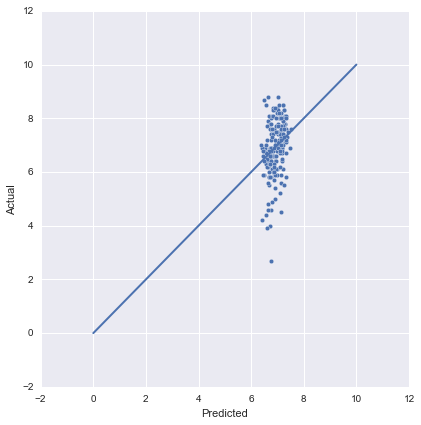

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pair = sns.pairplot(Results, x_vars=['Predicted'],y_vars = 'Actual', size=6)

plt.plot([0, 10], [0, 10], linewidth=2)

In [135]:
ranking = []
dif = []
for i in range(len(Results)-1):
    for j in range(len(Results)-1):
        ranking.append((Results.Predicted[i]-Results.Predicted[j])*(Results.Actual[i] - Results.Actual[j])>=0)
        dif.append(np.abs(np.abs((Results.Predicted[i]-Results.Predicted[j]))- np.abs((Results.Actual[i] - Results.Actual[j]))))
error = pd.DataFrame(ranking, columns = ['ranking'])
error['error'] = dif
   

In [139]:
error.groupby('ranking').describe()

error
ranking                    
False   count  12924.000000
        mean       0.803252
        std        0.785932
        min        0.000107
        25%        0.217842
        50%        0.555773
        75%        1.164296
        max        5.965607
True    count  23176.000000
        mean       0.941939
        std        0.886401
        min        0.000000
        25%        0.263263
        50%        0.680115
        75%        1.365113
        max        5.839511

In [137]:
error.ranking.value_counts()

True     23176
False    12924
Name: ranking, dtype: int64

In [142]:
movie_revenue.head()

,title,script,Actors,Awards,Director,Genre,Runtime,Writer,imdbRating,sentiment,sentiment_avg,sentiment_stdev
0,10 Things I Hate About You,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Heath Ledger, Julia Stiles, Joseph Gordon-Levi...",0,Gil Junger,"Comedy, Drama, Romance",97 min,"Karen McCullah, Kirsten Smith",7.2,"[0.11383952936, 0.105862606283, 0.081115874257...",0.050608,0.060887
1,12 and Holding,\n \n \n \n ...,"Conor Donovan, Jesse Camacho, Zoe Weizenbaum, ...",0,Michael Cuesta,Drama,94 min,Anthony Cipriano,7.6,"[0.0166268533054, -0.00886338353005, -0.051273...",0.012207,0.075825
2,12 Years a Slave,\n\r\n\r\n\r\n 12 ...,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...",1,Steve McQueen,"Biography, Drama, History",134 min,"John Ridley (screenplay), Solomon Northup (bas...",8.1,"[0.144452514765, 0.152337532525, 0.14795544635...",0.049629,0.064201
3,127 Hours,\n\r\n\r\n \r\n ...,"James Franco, Kate Mara, Amber Tamblyn, Sean Bott",1,Danny Boyle,"Adventure, Biography, Drama",94 min,"Danny Boyle (screenplay), Simon Beaufoy (scree...",7.6,"[-0.00192164832522, -0.00922014348086, -0.0075...",0.052450,0.061374
4,1492: Conquest of Paradise,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,"Gérard Depardieu, Armand Assante, Sigourney We...",0,Ridley Scott,"Adventure, Biography, Drama",154 min,Rose Bosch (scenario),6.5,"[0.133802253193, 0.121926184817, 0.08588619306...",0.040886,0.068049


In [141]:
movie_revenue = pd.read_pickle('movie_revenues.pkl')
np.abs(movie_revenue.Revenue - movie_revenue.Revenue.mean()).mean()

AttributeError: 'DataFrame' object has no attribute 'Revenue'